In [31]:
import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime
import random
import haversine as hs
import os

##visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

#visualization of maps
import geopandas

import folium
from folium.plugins import HeatMap

from IPython.core.display import display, HTML

In [32]:
general_dataset = pd.read_csv('data/nyc/citi_bike_data.csv')

In [33]:
general_dataset.describe()

,Unnamed: 0,tripduration,start.station.id,start.station.latitude,start.station.longitude,end.station.id,end.station.latitude,end.station.longitude,bikeid,birth.year,age,log_trip
count,103049.000000,1.030490e+05,103049.000000,103049.000000,103049.000000,103049.000000,103049.000000,103049.000000,103049.000000,103049.000000,103049.000000,103049.000000
mean,51525.000000,1.210641e+03,3306.398995,40.722369,-74.046245,3306.168260,40.722070,-74.045774,35526.059418,1981.832158,37.690244,6.319960
std,29747.828282,1.972644e+04,186.093512,0.007171,0.011461,195.358018,0.007050,0.011327,7969.944942,10.637771,10.641295,0.940207
min,1.000000,6.100000e+01,3184.000000,40.711130,-74.083639,116.000000,40.701403,-74.083639,14585.000000,1930.000000,16.000000,4.110874
25%,25763.000000,2.840000e+02,3195.000000,40.716870,-74.050656,3195.000000,40.716870,-74.050389,29269.000000,1972.000000,29.000000,5.648974
50%,51525.000000,4.880000e+02,3210.000000,40.721124,-74.043845,3209.000000,40.721124,-74.043117,29680.000000,1984.000000,35.000000,6.190315
75%,77287.000000,9.730000e+02,3276.000000,40.727224,-74.037683,3276.000000,40.727224,-74.037683,42586.000000,1990.000000,47.000000,6.880384
max,103049.000000,3.261756e+06,3792.000000,40.748716,-74.032108,4069.000000,40.848282,-73.941343,47939.000000,2004.000000,90.000000,14.997776


In [34]:
general_dataset.rename(columns={'start.station.id': 'start_station_id',
                                'start.station.name': 'start_station_name',
                                'start.station.latitude': 'start_station_latitude',
                                'start.station.longitude': 'start_station_longitude',
                                'end.station.id': 'end_station_id',
                                'end.station.name': 'end_station_name',
                                'end.station.latitude': 'end_station_latitude',
                                'end.station.longitude': 'end_station_longitude'}, inplace = True)

In [35]:
general_dataset["gender"] = general_dataset["gender"].fillna(random.choice(["M", "F"]))
#replace value gender 'F' and 'M' on 'male' and 'female'
general_dataset['gender'].replace(['F', 'M'], ['female', 'male'], inplace=True)

In [36]:
general_dataset = general_dataset.drop(['Unnamed: 0', 'birth.year', 'year'], axis = 1)

In [37]:
general_dataset['starttime'] = pd.to_datetime(general_dataset['starttime'])
general_dataset['stoptime'] = pd.to_datetime(general_dataset['stoptime'])

In [38]:
general_dataset['trip_type_by_duration'] = np.where(general_dataset['tripduration'] < 3600, "short trip", np.where(
    (general_dataset['tripduration'] > 3600) & (general_dataset['tripduration'] < 3600 * 24), "average trip", np.where(
    (general_dataset['tripduration'] > 3600 * 24) & (general_dataset['tripduration'] < 3600 * 24 * 30), "long trip",
        "extra long trip")))

general_dataset['age_group'] = np.where(general_dataset['age'] < 18, '[0, 18]', np.where(
    (general_dataset['age'] >= 18) & (general_dataset['age'] < 30), '[18, 30]', np.where(
    (general_dataset['age'] >= 30) & (general_dataset['age'] < 50), '[30, 50]', np.where(
    (general_dataset['age'] >= 50) & (general_dataset['age'] < 70), '[50, 70]', '[70+]'))))

general_dataset['start_station_location'] = general_dataset[['start_station_latitude',
                                                             'start_station_longitude']].values.tolist()
general_dataset['end_station_location'] = general_dataset[['end_station_latitude', 
                                                           'end_station_longitude']].values.tolist()

general_dataset = general_dataset.drop(['start_station_latitude', 
                                        'start_station_longitude', 
                                        'end_station_latitude',
                                        'end_station_longitude'], axis = 1)

In [39]:
general_dataset.head()

,tripduration,starttime,stoptime,start_station_id,start_station_name,end_station_id,end_station_name,bikeid,usertype,gender,age,log_trip,trip_type_by_duration,age_group,start_station_location,end_station_location
0,222,2020-09-01 00:15:58.647,2020-09-01 00:19:40.875,3186,Grove St PATH,3276,Marin Light Rail,45656,Subscriber,male,28,5.402677,short trip,"[18, 30]","[40.7195861164717, -74.0431174635887]","[40.7145840353589, -74.042817056179]"
1,193,2020-09-01 00:49:00.737,2020-09-01 00:52:14.364,3640,Journal Square,3206,Hilltop,45352,Subscriber,male,29,5.262690,short trip,"[18, 30]","[40.733670000000004, -74.0625]","[40.7311689, -74.0575736]"
2,273,2020-09-01 00:51:44.587,2020-09-01 00:56:17.716,3191,Union St,3694,Jackson Square,44424,Subscriber,male,51,5.609472,short trip,"[50, 70]","[40.71821129999999, -74.08363940000001]","[40.71113, -74.0789]"
3,1419,2020-09-01 00:52:48.316,2020-09-01 01:16:28.049,3203,Hamilton Park,3270,Jersey & 6th St,42240,Subscriber,male,34,7.257708,short trip,"[30, 50]","[40.727595965999996, -74.044247311]","[40.7252891078113, -74.0455716848373]"
4,254,2020-09-01 00:56:16.717,2020-09-01 01:00:31.087,3194,McGinley Square,3679,Bergen Ave,42434,Subscriber,male,28,5.537334,short trip,"[18, 30]","[40.7253399253558, -74.06762212514879]","[40.722103786686, -74.0714550018311]"


In [40]:
#dataset with start station name, start station location and count of starts
start_trip_info = general_dataset.groupby('start_station_name').agg({'start_station_name':'count'}).rename(
    columns={'start_station_name' : 'count_of_starts'}).reset_index().sort_values(by = 'start_station_name')

start_trip_info['start_station_location'] = general_dataset[['start_station_name', 'start_station_location']].drop_duplicates(
    subset='start_station_name').sort_values(by='start_station_name').reset_index(drop=True)['start_station_location']

#dataset with end station name, end station location and count of ends
end_trip_info = general_dataset.groupby('end_station_name').agg({'end_station_name':'count'}).rename(
    columns={'end_station_name' : 'count_of_ends'}).reset_index().sort_values(by = 'end_station_name')

end_trip_info['end_station_location'] = general_dataset[['end_station_name', 'end_station_location']].drop_duplicates(
    subset='end_station_name').sort_values(by='end_station_name').reset_index(drop=True)['end_station_location']

#dataset with station name, station location and sum of starts and ends
count_of_trips_by_stations = end_trip_info.merge(
    start_trip_info.rename(columns={'start_station_name': 'end_station_name'}), how='outer',
    on='end_station_name').rename(columns={'end_station_name': 'station_name'})

count_of_trips_by_stations['sum_of_starts_and_ends'] = (count_of_trips_by_stations['count_of_starts'].fillna(0) \
                                        + count_of_trips_by_stations['count_of_ends']).astype('int')

count_of_trips_by_stations = count_of_trips_by_stations.drop(
    ['count_of_starts', 'count_of_ends', 'end_station_location', 'start_station_location'], axis =1)
count_of_trips_by_stations = count_of_trips_by_stations.sort_values(by = 'sum_of_starts_and_ends', ascending=False).reset_index(
    drop=True)

In [41]:
# map stations which start the trips
map_points_of_start = folium.Map(location=[40.693943, -73.985880], default_zoom_start=12)
for point in start_trip_info.index:
    iframe = folium.IFrame(f'Station:"{start_trip_info["start_station_name"][point]}" <br>' 
                           f'Count of started trips:{start_trip_info["count_of_starts"][point]}')
    popup = folium.Popup(iframe, min_width=250, max_width=250)
    folium.Marker(start_trip_info['start_station_location'][point], popup=popup,
              icon=folium.Icon(color='darkblue', icon='bicycle', prefix='fa')).add_to(map_points_of_start)
    
# map stations which end the trips
map_points_of_end = folium.Map(location=[40.693943, -73.985880], default_zoom_start=12)
for point in end_trip_info.index:
    iframe = folium.IFrame(f'Station:"{end_trip_info["end_station_name"][point]}" <br>' 
                           f'Count of ended trips:{end_trip_info["count_of_ends"][point]}')
    popup = folium.Popup(iframe, min_width=250, max_width=250)
    folium.Marker(end_trip_info['end_station_location'][point], popup=popup,
                icon=folium.Icon(color='green', icon='home')).add_to(map_points_of_end)
    
# create subplots
htmlmap = HTML('<iframe srcdoc="{}" style="float:left; width: {}px; height: {}px; display:inline-block; width: 50%; margin: 0 auto; border: 2px solid black"></iframe>'
           '<iframe srcdoc="{}" style="float:right; width: {}px; height: {}px; display:inline-block; width: 50%; margin: 0 auto; border: 2px solid black"></iframe>'
           .format(map_points_of_start.get_root().render().replace('"', '&quot;'),500,500,
                   map_points_of_end.get_root().render().replace('"', '&quot;'),500,500))
display(htmlmap)

D:\Anaconda\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


[Text(0, 0.5, ''), Text(0.5, 0, 'sum of starts and ends by stations')]

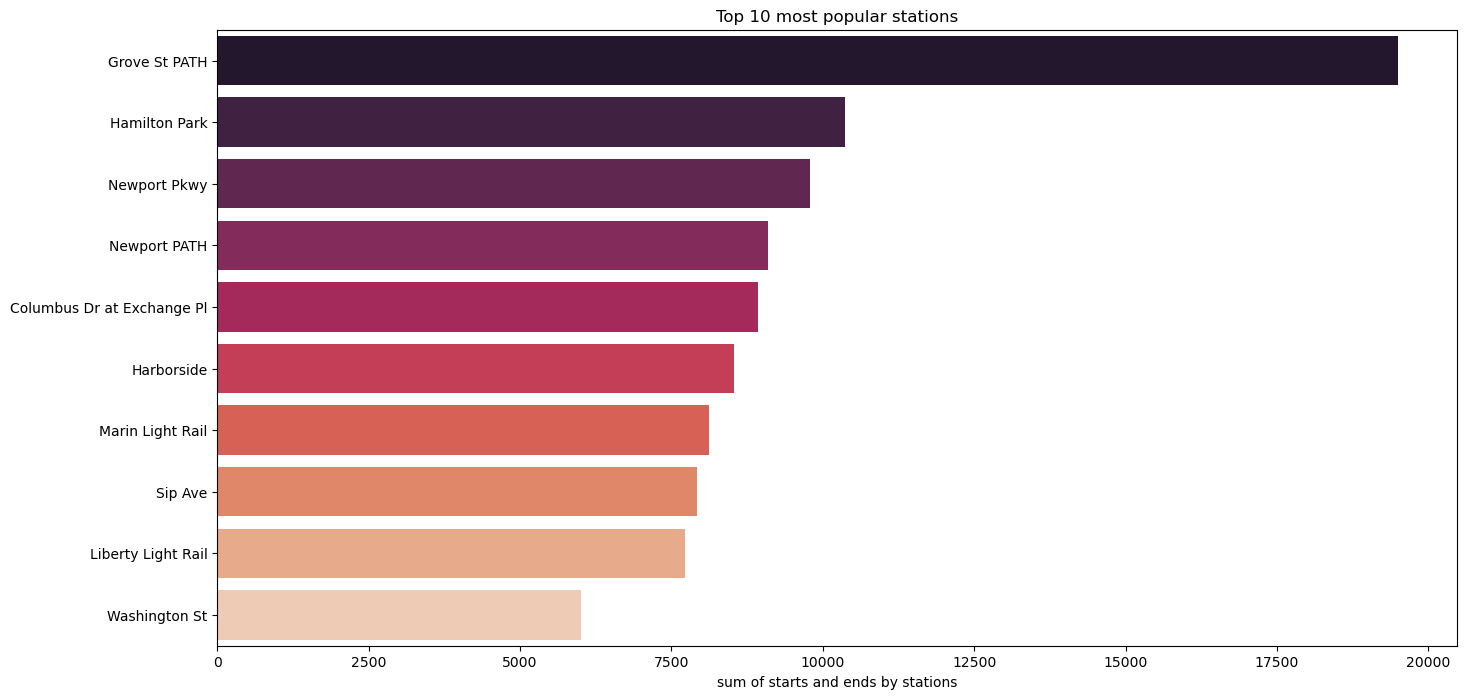

In [42]:
#top stations
plt.figure(figsize=(16,8))
plt.title('Top 10 most popular stations')
ax = sns.barplot(x='sum_of_starts_and_ends', 
                 y='station_name', 
                 data=count_of_trips_by_stations[:10], 
                 palette="rocket")
ax.set(ylabel=None, xlabel="sum of starts and ends by stations")

In [43]:
heatmap_start_trip = folium.Map(location=[40.7128,-73.9352], default_zoom_start=12)
heatmap = HeatMap(end_trip_info['end_station_location'], max_zoom=1).add_to(heatmap_start_trip)
heatmap_start_trip

In [44]:
route = pd.DataFrame({'route' : general_dataset['start_station_name'] + ' - '
                                     + general_dataset['end_station_name'],
                     'location' : general_dataset['start_station_location'] 
                                     + general_dataset['end_station_location']})
route['location'] = route['location'].apply(lambda x: tuple(x))
routes_info = route.groupby('route').count().reset_index().rename(columns = {'location': 'number_of_trips'})
route_locations = route.sort_values(by='route').drop_duplicates().reset_index(drop = True)
routes_info['location'] = route_locations['location'].apply(lambda x: list(x))
routes_info = routes_info.sort_values(by = 'number_of_trips', ascending=False).reset_index(drop=True)
routes_info.head()

,route,number_of_trips,location
0,Liberty Light Rail - Liberty Light Rail,1337,"[40.711242299999995, -74.0557013, 40.711242299..."
1,Hamilton Park - Grove St PATH,1243,"[40.727595965999996, -74.044247311, 40.7195861..."
2,Newport Pkwy - Newport Pkwy,1042,"[40.728744799999994, -74.03210820000001, 40.72..."
3,Grove St PATH - Hamilton Park,936,"[40.7195861164717, -74.0431174635887, 40.72759..."
4,McGinley Square - Sip Ave,837,"[40.7253399253558, -74.06762212514879, 40.7308..."


Text(0, 0.5, 'route')

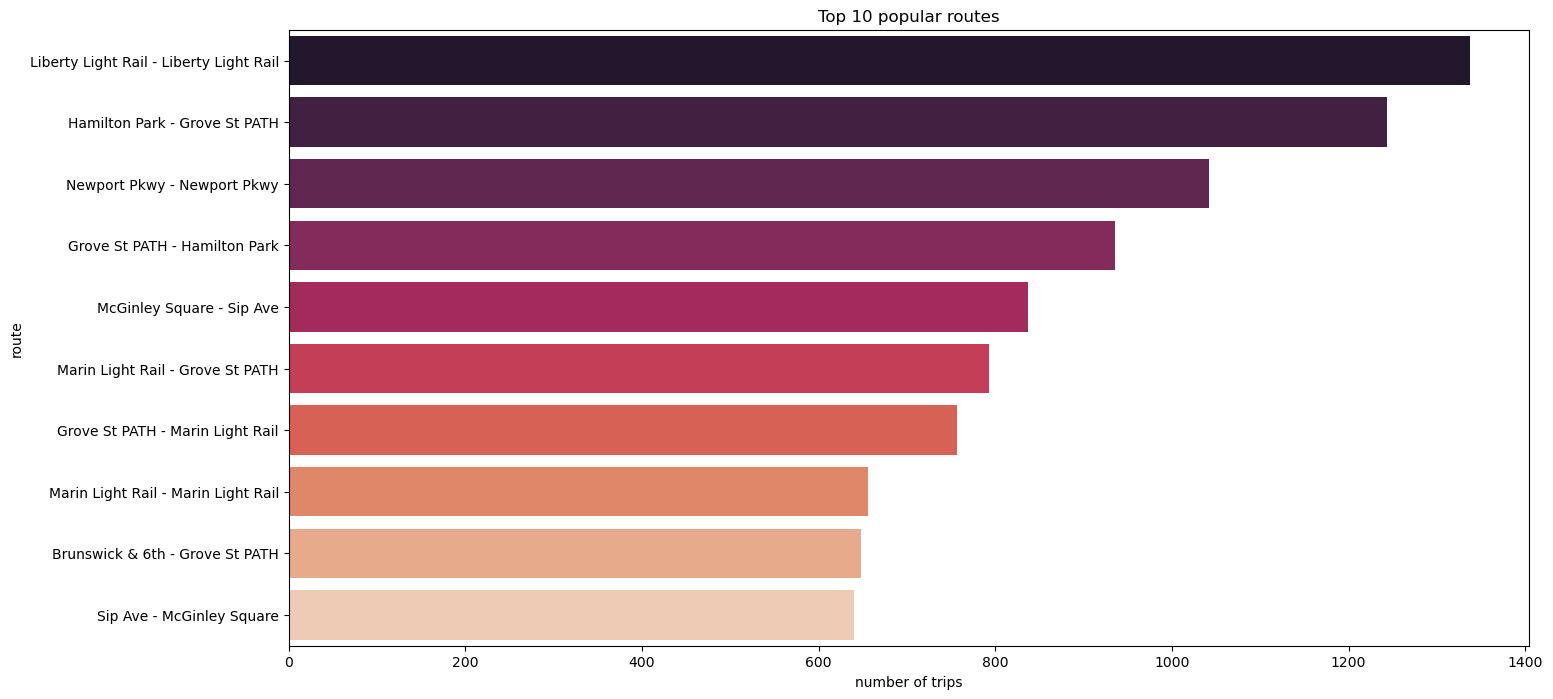

In [45]:
plt.figure(figsize=(16,8))
plt.title('Top 10 popular routes')
sns.barplot(y = routes_info['route'][:10], x = routes_info['number_of_trips'][:10],  palette="rocket")
plt.xlabel('number of trips')
plt.ylabel('route')

In [46]:
map_top_popular_routes = folium.Map(location=[40.693943, -73.985880], default_zoom_start=12)
for point in routes_info.index:
    if point  < 3:
        iframe_s = folium.IFrame(f'Start of route "{routes_info["route"][point]}"')
        popup_s = folium.Popup(iframe_s, min_width=300, max_width=300)
        folium.Marker(routes_info['location'][point][:2], popup=popup_s, icon=folium.Icon(
            color='blue',  icon='bicycle', prefix='fa')).add_to(map_top_popular_routes)
        
        iframe_e = folium.IFrame(f'End of route "{routes_info["route"][point]}"')
        popup_e = folium.Popup(iframe_e, min_width=300, max_width=300)
        folium.Marker(routes_info['location'][point][2:], popup=popup_e, icon=folium.Icon(color='green', icon='home')) \
            .add_to(map_top_popular_routes)
        folium.PolyLine([(routes_info['location'][point][:2], routes_info['location'][point][2:])], 
                        color='red').add_to(map_top_popular_routes)
    else:
        break
map_top_popular_routes

Text(0.5, 0, 'starttime by dayofweek')

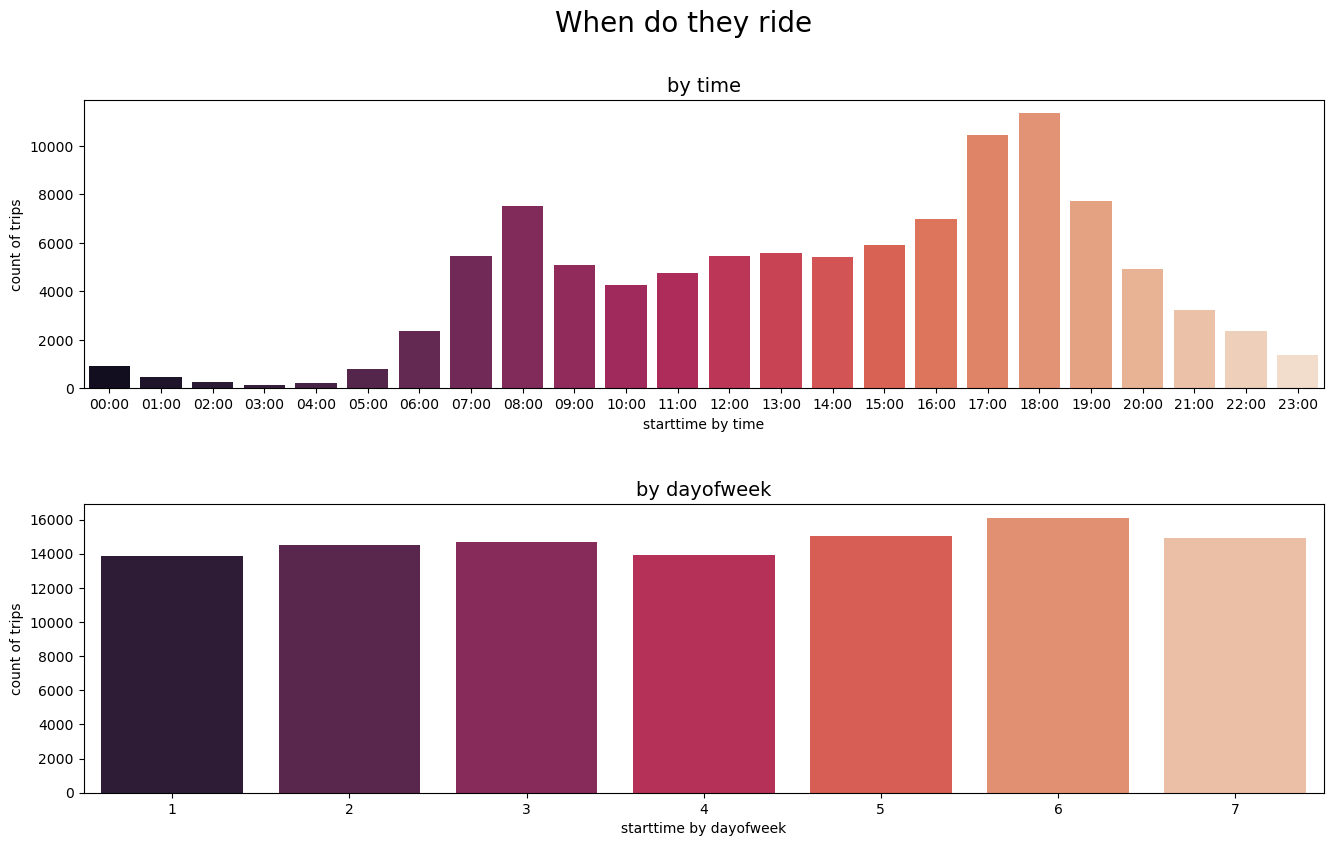

In [47]:
general_dataset['starttime_by_hours'] = general_dataset['starttime'].dt.strftime('%H:00')
general_dataset['starttime_by_dayofweek'] = general_dataset['starttime'].dt.dayofweek+1


count_of_trips_groupby_hours = general_dataset.groupby('starttime_by_hours').agg({'starttime_by_hours':'count'}).rename(
    columns = {'starttime_by_hours':'count_of_trips'}).reset_index()
count_of_trips_groupby_dayofweeks = general_dataset.groupby('starttime_by_dayofweek').agg(
    {'starttime_by_dayofweek':'count'}).rename(columns = {'starttime_by_dayofweek':'count_of_trips'}).reset_index()

fig, axes = plt.subplots(2, 1, figsize=(16,9))
plt.subplots_adjust(hspace=0.4)
fig.suptitle('When do they ride', size = 20)

sns.barplot(ax=axes[0], x='starttime_by_hours', y='count_of_trips', data=count_of_trips_groupby_hours,  palette="rocket")
axes[0].set_title("by time", size = 14)
axes[0].set_ylabel('count of trips')
axes[0].set_xlabel('starttime by time')

sns.barplot(ax=axes[1], x='starttime_by_dayofweek', y='count_of_trips', data=count_of_trips_groupby_dayofweeks,
            palette="rocket").set(title='by dayofweek')
axes[1].set_title("by dayofweek", size = 14)
axes[1].set_ylabel('count of trips')
axes[1].set_xlabel('starttime by dayofweek')

In [48]:
# the function of measurement the distance of the route in kilometers
def distance_measurement(start_location: pd.Series, end_location: pd.Series) -> pd.Series:
    list_of_distances = []
    for loc1, loc2 in zip(start_location.apply(lambda x: tuple(x)), end_location.apply(lambda x: tuple(x))):
        list_of_distances.append(hs.haversine(loc1, loc2))
    return pd.Series(list_of_distances)

general_dataset['route_distance'] = distance_measurement(general_dataset['start_station_location'], 
                                                         general_dataset['end_station_location'])

In [49]:
general_dataset.head()

,tripduration,starttime,stoptime,start_station_id,start_station_name,end_station_id,end_station_name,bikeid,usertype,gender,age,log_trip,trip_type_by_duration,age_group,start_station_location,end_station_location,starttime_by_hours,starttime_by_dayofweek,route_distance
0,222,2020-09-01 00:15:58.647,2020-09-01 00:19:40.875,3186,Grove St PATH,3276,Marin Light Rail,45656,Subscriber,male,28,5.402677,short trip,"[18, 30]","[40.7195861164717, -74.0431174635887]","[40.7145840353589, -74.042817056179]",00:00,2,0.556783
1,193,2020-09-01 00:49:00.737,2020-09-01 00:52:14.364,3640,Journal Square,3206,Hilltop,45352,Subscriber,male,29,5.262690,short trip,"[18, 30]","[40.733670000000004, -74.0625]","[40.7311689, -74.0575736]",00:00,2,0.499651
2,273,2020-09-01 00:51:44.587,2020-09-01 00:56:17.716,3191,Union St,3694,Jackson Square,44424,Subscriber,male,51,5.609472,short trip,"[50, 70]","[40.71821129999999, -74.08363940000001]","[40.71113, -74.0789]",00:00,2,0.882930
3,1419,2020-09-01 00:52:48.316,2020-09-01 01:16:28.049,3203,Hamilton Park,3270,Jersey & 6th St,42240,Subscriber,male,34,7.257708,short trip,"[30, 50]","[40.727595965999996, -74.044247311]","[40.7252891078113, -74.0455716848373]",00:00,2,0.279737
4,254,2020-09-01 00:56:16.717,2020-09-01 01:00:31.087,3194,McGinley Square,3679,Bergen Ave,42434,Subscriber,male,28,5.537334,short trip,"[18, 30]","[40.7253399253558, -74.06762212514879]","[40.722103786686, -74.0714550018311]",00:00,2,0.483545


In [50]:
max_distance_id = general_dataset['route_distance'].idxmax()

print(f'The longest route between the station where the trip started and where it ended is:')
print(f'"{general_dataset.start_station_name[max_distance_id]} - {general_dataset.end_station_name[max_distance_id]}", '
      f'distance - {general_dataset["route_distance"][max_distance_id]}km.\n')

longest_route_map = folium.Map(location=[40.693943, -73.985880], default_zoom_start=12)
iframe_s = folium.IFrame(f'Start route "{general_dataset["start_station_name"][max_distance_id]}"')
popup_s = folium.Popup(iframe_s, min_width=200, max_width=200)
folium.Marker(general_dataset['start_station_location'][max_distance_id], popup=popup_s, icon=folium.Icon(
    color='blue',  icon='bicycle', prefix='fa')).add_to(longest_route_map)
        
iframe_e = folium.IFrame(f'End route "{general_dataset["end_station_name"][max_distance_id]}"')
popup_e = folium.Popup(iframe_e, min_width=300, max_width=300)
folium.Marker(general_dataset['end_station_location'][max_distance_id], popup=popup_e, icon=folium.Icon(
    color='green', icon='home')).add_to(longest_route_map)

folium.PolyLine([(general_dataset['start_station_location'][max_distance_id], 
    general_dataset['end_station_location'][max_distance_id])], color='red').add_to(longest_route_map)
longest_route_map

The longest route between the station where the trip started and where it ended is:
"Columbus Dr at Exchange Pl - Cabrini Blvd & W 177 St", distance - 16.51754548231762km.



Text(0, 0.5, 'count of riders')

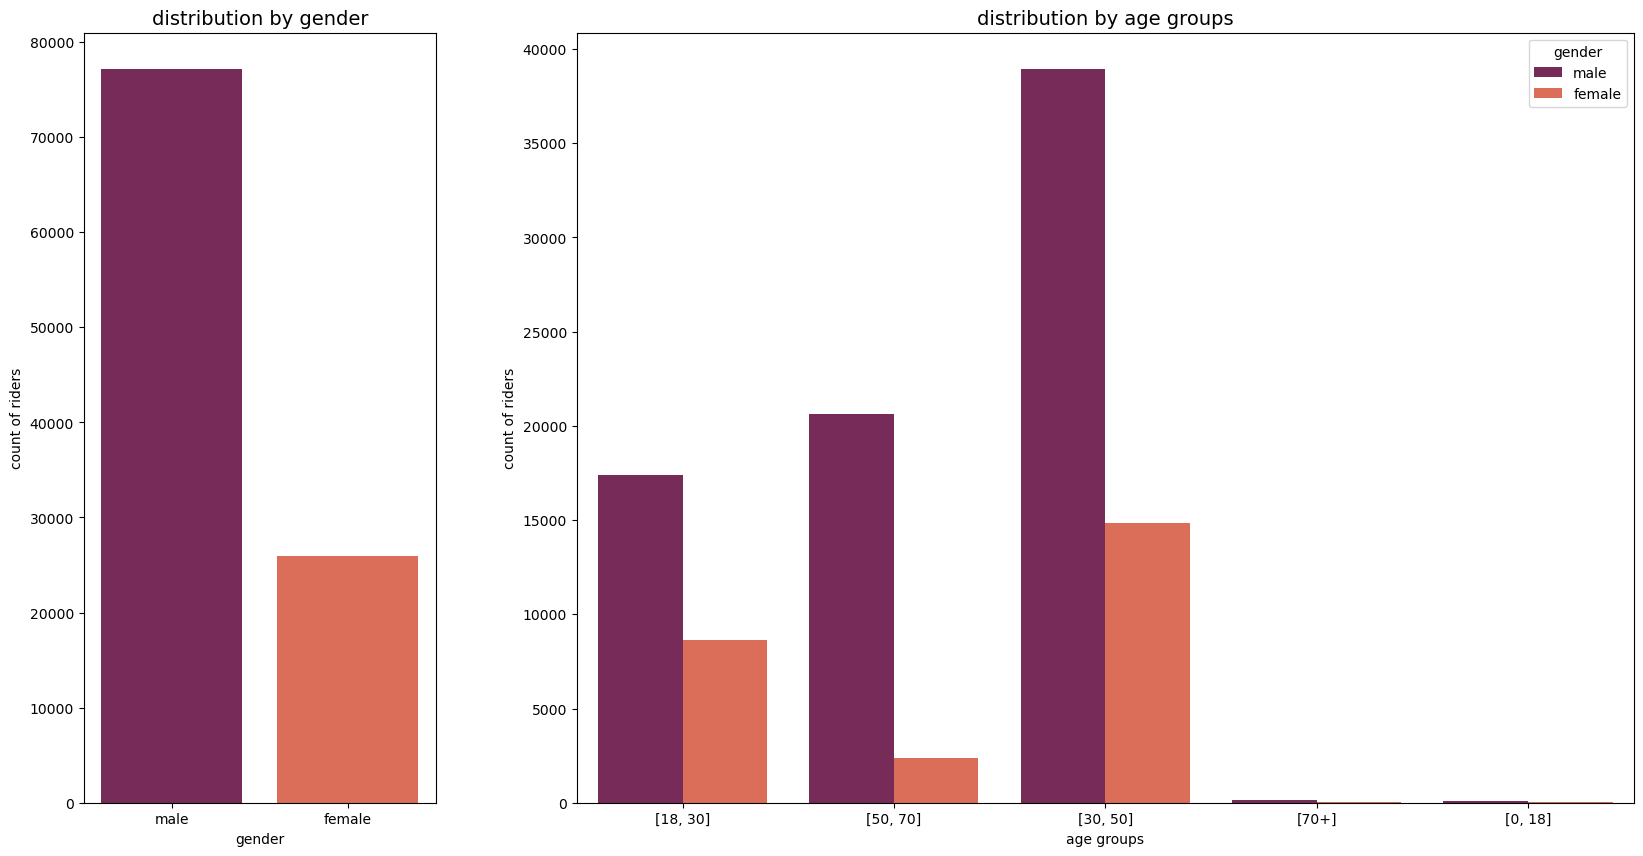

In [51]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10),  gridspec_kw={'width_ratios': [1, 3]})

sns.countplot(ax = axes[0], x='gender', data=general_dataset, palette="rocket")
axes[0].set_title("distribution by gender", size = 14)
axes[0].set_xlabel('gender')
axes[0].set_ylabel('count of riders')

sns.countplot(ax = axes[1], x='age_group', hue = 'gender',  data=general_dataset, palette="rocket")
axes[1].set_title("distribution by age groups", size = 14)
axes[1].set_xlabel('age groups')
axes[1].set_ylabel('count of riders')

Text(0, 0.5, 'count of riders')

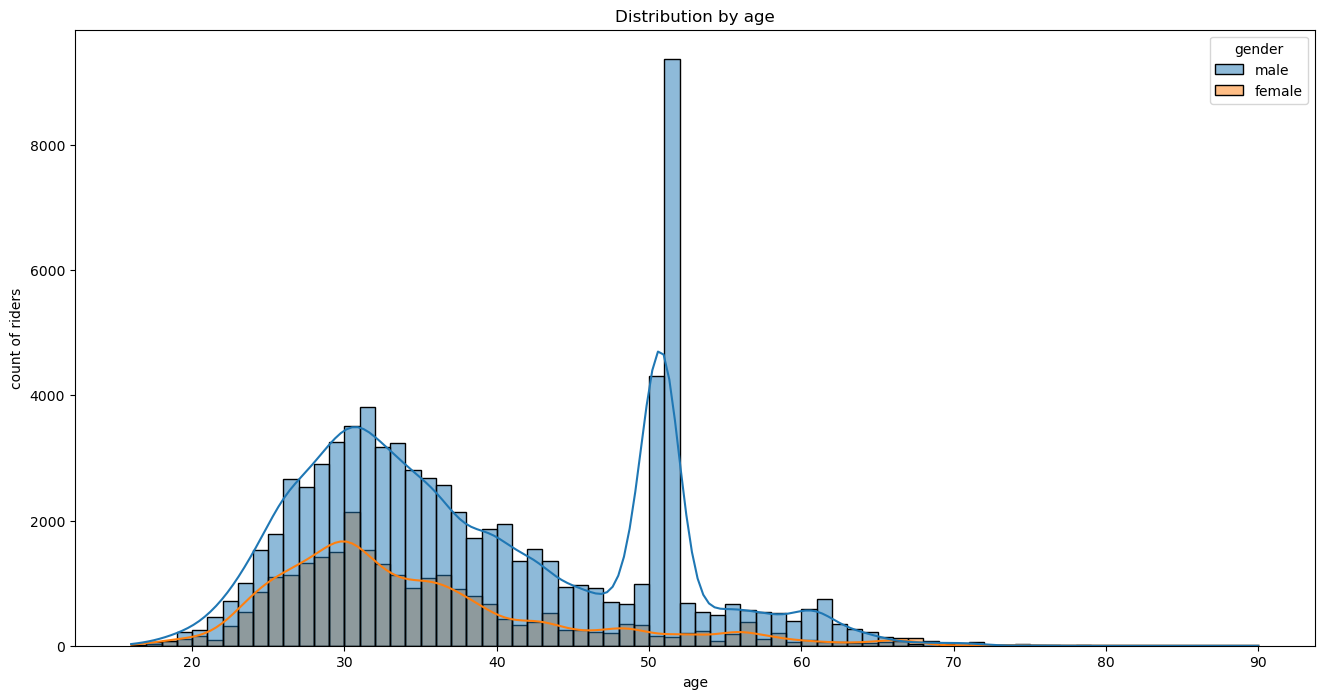

In [52]:
plt.figure(figsize=(16,8))
plt.title('Distribution by age')
sns.histplot(data=general_dataset, x="age", hue = 'gender', binwidth=1, kde = True)
plt.ylabel('count of riders')